## Import Data and Libraries

In [1]:
# standard
import os
import pandas as pd
import numpy as np

# preprocessing
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# cross validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# metrics 
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.metrics import make_scorer

#plotting
import seaborn as sn
import matplotlib.pyplot as plt
import ipywidgets as widgets

# sklearn fixed random state
rs = 7

%matplotlib inline

In [2]:
# import data (train and test)
df = pd.read_csv("data/train.csv")

display(df.head())
display(df.info())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

## Data Exploration

In [29]:
# Data exploration with ipywidgets
def scatter_plot(dataframe, x, y):
    ax = dataframe.plot.scatter(x=x, y=y)

def bar_plot(dataframe, x):
    ax = dataframe[x].hist()

_ = widgets.interact(scatter_plot, dataframe=widgets.fixed(df), x=list(df.columns), y=list(df.columns))

interactive(children=(Dropdown(description='x', options=('Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotAr…

In [4]:
_ = widgets.interact(bar_plot, dataframe=widgets.fixed(df), x=list(df.columns))

interactive(children=(Dropdown(description='x', options=('Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotAr…

1stFlrSF and TotalBsmtSF -> corr = 0.82
GrLivArea and TotRmsAbvGrd -> corr = 0.83
GarageYrBlt and YearBuilt -> corr = 0.83
GarageArea and GarageCars -> corr = 0.88


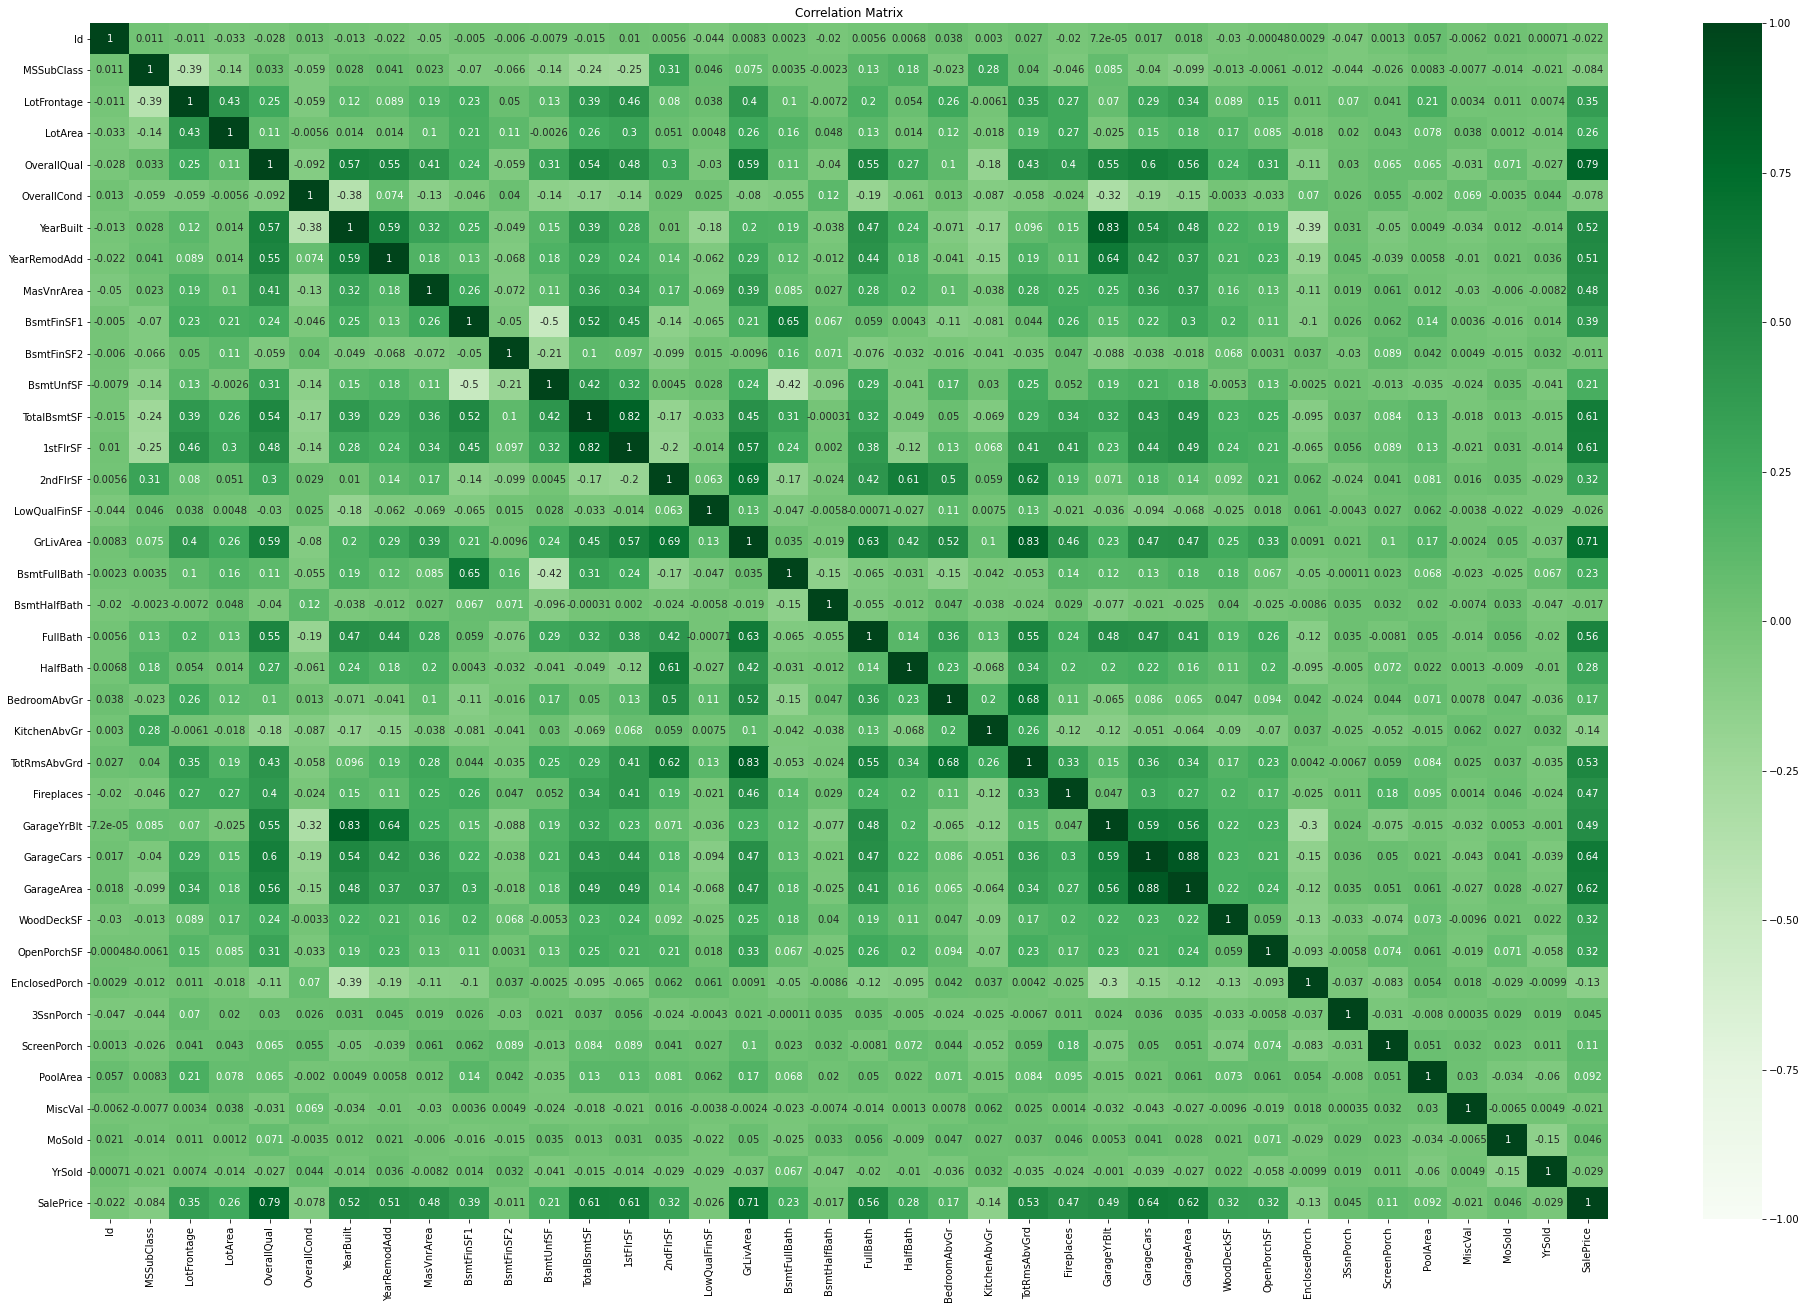

In [5]:
# Plot correlation matrix
# We might decide to remove the highly correlated variables
corr_matrix = df.corr()
fig = plt.figure(figsize = (34,22))
ax = fig.gca()
plt.title('Correlation Matrix')
sn.heatmap(corr_matrix, cmap='Greens', vmin=-1, vmax=1, annot=True)

# Deep dive into the highly correlated features
# This is useful, functionise it
def check_correlations(df, target=None, corr_threshold=0.7):
    corr_matrix = df.corr()
    r_count = 0 
    for r_index, row in corr_matrix.iterrows():
        r_count += 1
        c_count = 0
        for c_index, value in row.iteritems():
            # if it's something we haven't seen before
            if (r_index!=target) & (c_index!=target) & (c_index > r_index):
                # if it's super correlated
                if (abs(value) >= corr_threshold):
                    print("%s and %s -> corr = %0.2f" % (r_index, c_index, value))
            c_count += 1

check_correlations(df, target='SalePrice')

## Data pre-processing

In [6]:
# Drop the non-populated features
# we choose arbitrary min number of values per fearure as half the num of observations
# Good thing sale price (target var) has no missing values, we would have to drop those if we had any...
drop_cols = []
mv_cols = []
for col in df.columns:
    # store the columns we want to drop in a list
    if df[col].count() < len(df)/2:
        drop_cols.append(col)
    # store the columns where we'll have to deal with missing vlaues in another list
    elif df[col].count() < len(df): 
        mv_cols.append(col)

# drop columns
df = df.drop(columns=drop_cols)

In [7]:
# Remove fields that are intuitively useless
df.drop(columns=['MiscVal'], inplace=True)

# Remove the very correlated features (and sense checking the descriptions...)
df.drop(columns=["GarageArea", #Similar to Garage Cars
                 "GarageYrBlt", # Similar to Year Built
                 "TotRmsAbvGrd", # Similar to GrLivArea
                ],
        inplace=True
       )

**Identify the categorical variables**

In [8]:
# Explore the categorical variables
# Note: MSSubClass is also categorical but it's already label encoded (info from data description)
c_vars = list(df.select_dtypes(include=['object']).columns)
print("There are %d categorical variables"%len(c_vars))
display(df[c_vars].head())

There are 39 categorical variables


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


**Missing values**  
We'll use the mode for the categorical variables and the mean for the numerical

In [9]:
# Mode for categrical mean for numerical
# store in dictionar to use for the test set
mising_vals = {}
for col in df.columns:
    if col in c_vars:
        m = df[col].mode()[0]
        mising_vals[col] = m
        df[col].fillna(m, inplace=True)
    else:
        m = df[col].mean()
        mising_vals[col] = m
        df[col].fillna(m, inplace=True)

display(df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,12,2008,WD,Normal,250000


**To one-hot-encode or to label encode, that is the question...**  
Depending on the algorithm we'll use we'll either have to one-hot encode the categorival variables or label encode them.  
In this notebook we'll explore and compare the performance of tree based algorithms (e.g. Random Forest and XGBoost).  
For the tree based algorithms and for the data at hand it's best to **label encode** the categorical variables. 
One-hot encoding will result in dramatically increasing the number of features.  
  
Ideally we would try to maintain any ordinal properties of the features in the label encoding - However that will take some time so we'll skip it for now.

In [10]:
# Store in a dict for the prediction phase
le_dict = {}
for col in c_vars:
    le = LabelEncoder()
    #le.impute_method = 'most_common'
    le.fit(df[col])
    le_dict[col] = le
    df[col] = le.transform(df[col])

In [11]:
display(df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,61,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,...,42,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,...,35,272,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,...,84,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,3,3,0,4,...,40,0,0,0,0,8,2007,8,4,175000
1456,1457,20,3,85.0,13175,1,3,3,0,4,...,0,0,0,0,0,2,2010,8,4,210000
1457,1458,70,3,66.0,9042,1,3,3,0,4,...,60,0,0,0,0,5,2010,8,4,266500
1458,1459,20,3,68.0,9717,1,3,3,0,4,...,0,112,0,0,0,4,2010,8,4,142125


**Additional steps**  
If we used algorithms like linear algorithms like ElasticNet, Linear regression etc. we would have to: 
* Create a set with one-hot-encoded categorical variables
* Normalise the data (e.g. min-max scaling)
* (optional) remove highly correlated variables

In [12]:
# Split the data in X (poredictors), y (target)
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

## Models

In [13]:
# Split data in train - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs, shuffle=True)
# remove id from features
id_train, id_test, id_all = X_train['Id'], X_test['Id'], X['Id']
X_train = X_train.drop(columns='Id')
X_test = X_test.drop(columns='Id')
X = X.drop(columns='Id')

### 1. Random Forest Regression

**Note:** The square root is a monotonically increasing function, thus for the grid search using the mean square log error (sklearn built in metric) is equivalent to using it's square root. We can then take the square root to report the Root Mean Squared Error of the logs.

In [14]:
# fix random state to get same results in later runs
rf = RandomForestRegressor(random_state=rs)

# We'll keep the grid search light cause it takes a long time
params = {'max_depth': [10, 100, None],
          'n_estimators': [100, 500, 1000]}

rf_gs = GridSearchCV(rf, param_grid=params, scoring="neg_mean_squared_log_error", cv=3)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=7,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [15]:
print('The RMSLE for the best estimator is %0.2f' % np.sqrt(-rf_gs.best_score_))

The RMSLE for the best estimator is 0.15


In [16]:
# calculate the R squared in the test set
y_test_pred = rf_gs.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
R_2 = r2_score(y_test, y_test_pred)
print("The R squared on the test set is %0.2f"%R_2)
print("The root mean square log error on the test set is %0.2f"%rmsle)

The R squared on the test set is 0.91
The root mean square log error on the test set is 0.13


### 2. XGBoost Regression

In [17]:
# fix random state to get same results in later runs
xgb = XGBRegressor(random_state=rs)

# We'll keep the grid search light cause it takes a long time
params = {'max_depth': [3, 6, 10], 
          'n_estimators': [50, 100, 200, 500], 
          "learning_rate":[0.01, 0.1, 0.2],
          "lambda": [0.1, 1, 10]}

xgb_gs = GridSearchCV(xgb, param_grid=params, scoring="neg_mean_squared_log_error", cv=5)
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_gri

In [18]:
print(xgb_gs.best_params_)

{'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


In [19]:
print('The RMSLE for the best estimator is %0.2f' % np.sqrt(-xgb_gs.best_score_))

The RMSLE for the best estimator is 0.14


In [20]:
# calculate the R squared in the test set
y_test_pred = xgb_gs.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
R_2 = r2_score(y_test, y_test_pred)
print("The R squared on the test set is %0.2f"%R_2)
print("The root mean square log error on the test set is %0.2f"%rmsle)

The R squared on the test set is 0.91
The root mean square log error on the test set is 0.12


### Fit the best regressor to the full dataset

In [21]:
best_model = XGBRegressor(random_state=rs)
# Set the parameters from the grid search
best_model.set_params(**xgb_gs.best_params_)
# fit to the full dataset
best_model.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None, lambda=1,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [22]:
# calculate the R squared in the test set
y_test_pred = best_model.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
R_2 = r2_score(y_test, y_test_pred)
print("The R squared on the test set is %0.2f"%R_2)
print("The root mean square log error on the test set is %0.2f"%rmsle)

The R squared on the test set is 0.99
The root mean square log error on the test set is 0.05


## Prediction

In [23]:
# import test
test = pd.read_csv("data/test.csv")

In [24]:
# Preprocess training data with the same values as in the train set 

# drop cols that we droped for the training set
test = test.drop(columns=drop_cols)

# Remove the features dropped during feature selection
# Remove fields that are intuitively useless
test.drop(columns=['MiscVal'], inplace=True)

# Remove the very correlated features (and sense checking the descriptions...)
test.drop(columns=["GarageArea", #Similar to Garage Cars
                   "GarageYrBlt", # Similar to Year Built
                   "TotRmsAbvGrd", # Similar to GrLivArea
                  ],
          inplace=True
         )

# missing values
for col in test.columns:
    if col in c_vars:
        m = mising_vals[col]
        test[col].fillna(m, inplace=True)
    else:
        m = mising_vals[col]
        test[col].fillna(m, inplace=True)

# label encoding using the same label encoder the was fitted with the train set
# If we get new label we're in trouble...
for col in c_vars:
    try: 
        test[col] = le_dict[col].transform(test[col])
    except ValueError as ex:
        print(ex)

In [25]:
test_id = test["Id"]
test.drop(columns=["Id"], inplace=True)
y_pred = best_model.predict(test)

In [26]:
results = pd.DataFrame()
results["Id"] = test_id
results["SalePrice"] = y_pred

In [27]:
display(results.head())

,Id,SalePrice
0,1461,121783.476562
1,1462,163124.281250
2,1463,176944.953125
3,1464,189525.437500
4,1465,178838.843750


In [28]:
results.to_csv("results.csv", index=False)